In [1]:
#Setting working path required for relative package loading

import os
os.chdir("/home/tales/ds/walmart-recruiting-store-sales-forecasting/")
print("working dir:", "\'" + os.getcwd() + "\'")

working dir: '/home/tales/ds/walmart-recruiting-store-sales-forecasting'


In [2]:
import pandas as pd

from src.data import dao
from src.processment import process
from src.utils import pretties, time_utils, stats
from src.visualization import plot
from bokeh.plotting import show, output_notebook

In [3]:
pretties.max_data_frame_columns()
pretties.decimal_notation()
output_notebook()

Loading BokehJS ...

# <font color="darkred">Relations</font>
with target variable

# walmart-recruiting-store-sales-forecasting
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

In [4]:
train = dao.load_dataset("train")
train = train.groupby("store_dept").apply(process.train_sales_semantic_enrichment)

feat = dao.load_features()
feat = process.features_semantic_enrichment(feat)

stores = dao.load_stores()

In [5]:
train = train.merge(feat, how="left", left_on=["Store", "Date"], right_on=["Store", "Date"], suffixes=["", "_y"])
del train["IsHoliday_y"]
del train["timestamp_y"]
train = train.merge(stores, how="left", left_on=["Store"], right_on=["Store"])

In [6]:
cols = ['Date', 'Store', 'Dept', 'Weekly_Sales', 'pre_holiday', 'IsHoliday', 'pos_holiday', 'Fuel_Price', 
        'CPI', 'Unemployment', 'celsius', 'datetime', 'Type', 'sales_diff', 'sales_diff_p',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
        'Size', 'Temperature', 'timestamp', 'store_dept', "day_n", "week_n", "month_n", "year", "wm_date", "up_diff", "celsius_diff"]

In [7]:
train = train[cols].sort_values("timestamp")

In [8]:
train.sample(6)

,Date,Store,Dept,Weekly_Sales,pre_holiday,IsHoliday,pos_holiday,Fuel_Price,CPI,Unemployment,celsius,datetime,Type,sales_diff,sales_diff_p,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,timestamp,store_dept,day_n,week_n,month_n,year,wm_date,up_diff,celsius_diff
348040,2012-05-11,16,3,5801.69,False,False,False,3.87,197.55,6.17,11.98,2012-05-11,B,519.50,0.10,4814.92,nan,61.11,343.64,837.48,57197,53.57,1336705200.00,16_3,11,2,05,2012,05/2,True,1.24
334319,2012-04-06,12,58,2880.00,False,False,False,4.12,131.04,11.63,17.81,2012-04-06,B,2235.00,3.47,11772.46,nan,61.63,3885.06,4225.11,112238,64.05,1333681200.00,12_58,6,1,04,2012,04/1,True,-0.17
395035,2012-08-31,45,23,19834.21,True,False,False,3.87,191.46,8.68,23.94,2012-08-31,B,-472.03,-0.02,23641.30,6.00,92.93,6988.31,3992.13,118221,75.09,1346382000.00,45_23,31,5,08,2012,08/5,False,1.37
163058,2011-02-25,23,97,5861.24,False,False,False,3.28,133.49,5.11,-8.33,2011-02-25,B,-651.96,-0.10,nan,nan,nan,nan,nan,114533,17.00,1298602800.00,23_97,25,4,02,2011,02/4,False,-5.33
19815,2010-03-19,8,14,10423.26,False,False,False,2.72,214.58,6.30,8.48,2010-03-19,A,575.23,0.06,nan,nan,nan,nan,nan,155078,47.26,1268967600.00,8_14,19,3,03,2010,03/3,True,-1.39
210763,2011-06-17,6,56,4127.88,False,False,False,3.64,216.54,6.86,30.60,2011-06-17,A,324.38,0.09,nan,nan,nan,nan,nan,202505,87.08,1308279600.00,6_56,17,3,06,2011,06/3,True,1.44


# <font color="navy">Date</font>

In [9]:
train["Date"].head(1).append(train["Date"].tail(1))

0         2010-02-05
421569    2012-10-26
Name: Date, dtype: object

In [10]:
p = plot.time_series_count_painted(train, title="Weekly_Sales vs Datetime", height=300, width=900)
p = plot.time_series_count_painted_holidays(train, p=p, color="cyan", alpha=0.9)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))
/home/tales/ds/walmart-recruiting-store-sales-forecasting/src/visualization/plot.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays["Date"] = holidays["Date"].apply(pd.to_datetime)


In [11]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", legend="All depts median", relative_y_axis=True, height=300)
p = plot.time_series_count_painted_holidays(train, p=p, color="cyan", alpha=0.9)
show(p)

In [12]:
from statsmodels.tsa.filters.hp_filter import hpfilter

gdp_cycle, gdp_trend = hpfilter(grouped_sales, lamb=1)

grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, gdp_trend, color="magenta", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=300, p=p)
show(p)

In [13]:
p = plot.plot_error_values(train, "week_n", "Weekly_Sales", drop_quantile=0.20, 
                           title="Weekly_Sales errors grouped by week_n")
show(p)

In [14]:
# p = plot.plot_error_values(train, "week_n", "sales_diff_p", drop_quantile=0.15, 
#                            title="Weekly_Sales errors grouped by week_n")
# show(p)

In [15]:
# train["wm_date"] = train["month_n"] + "/" + train["week_n"].astype(str)

In [16]:
p = plot.plot_error_values(train, "wm_date", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by wm_date", width=1200)
show(p)

In [17]:
# p = plot.plot_error_values(train, "wm_date", "sales_diff_p", drop_quantile=0.25, 
#                            title="sales_diff_p errors grouped by wm_date", width=1200)
# show(p)

# <font color="navy">Store</font>

In [18]:
train.groupby("Store")["Weekly_Sales"].mean().sort_values().plot.bar(title="Sales amout per store", figsize=(10, 3))

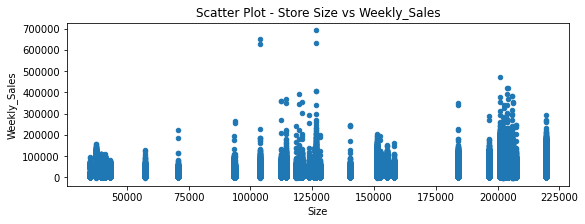

In [19]:
train.plot.scatter("Size", "Weekly_Sales", title="Scatter Plot - Store Size vs Weekly_Sales",figsize=(9,3))

# <font color="navy">IsHoliday</font>
holiday evaluation weight = 5 <br>
not holiday evaluation weight = 1

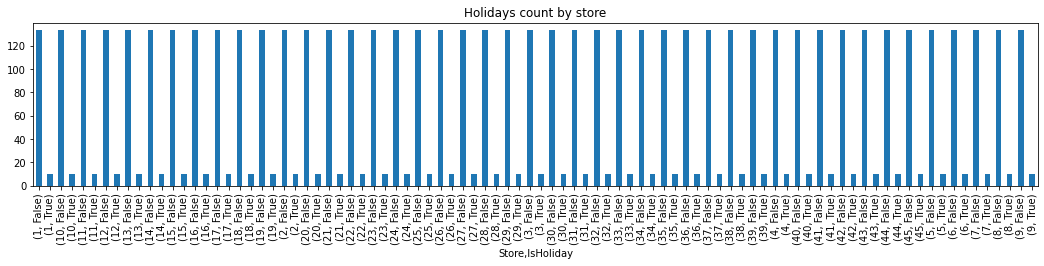

In [20]:
train.drop_duplicates(["Store", "Date"]).groupby("Store")["IsHoliday"].value_counts().plot.bar(title="Holidays count by store",figsize=(18,3))

In [21]:
stats.freq(train.drop_duplicates(["Store", "Date"])["IsHoliday"])

,freq_absolute,freq_relative
False,5985,93.01%
True,450,6.99%


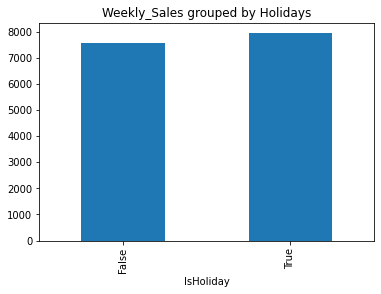

In [22]:
train.groupby("IsHoliday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales grouped by Holidays")

In [23]:
p = plot.plot_error_values(train, "IsHoliday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by IsHoliday")
show(p)

#### Before Holiday

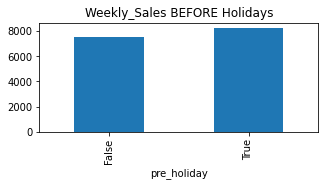

In [24]:
train.groupby("pre_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales BEFORE Holidays", figsize=(5,2))

In [25]:
p = plot.plot_error_values(train, "pre_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pre_holiday", width=350, height=200)
show(p)

#### After Holiday

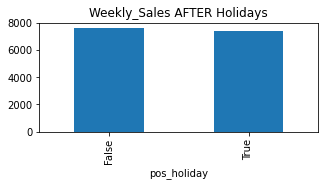

In [26]:
train.groupby("pos_holiday")["Weekly_Sales"].median().plot.bar(title="Weekly_Sales AFTER Holidays", figsize=(5,2))

In [27]:
p = plot.plot_error_values(train, "pos_holiday", "Weekly_Sales", drop_quantile=0.25, 
                           title="Weekly_Sales errors grouped by pos_holiday", width=350, height=200)
show(p)

# <font color="navy">Fuel_Price</font>

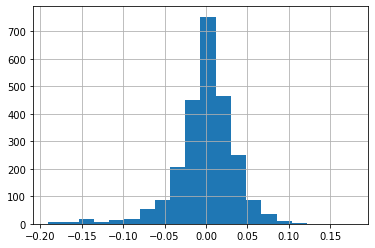

In [28]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Fuel_Price"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">CPI</font>

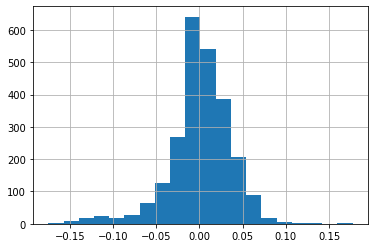

In [29]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["CPI"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Unemployment</font>

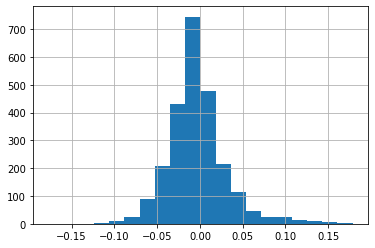

In [30]:
train.groupby(["Store", "wm_date"]).apply(lambda g : g["Unemployment"].corr(g["Weekly_Sales"])).hist(bins=20)

It seems that Fuel_Price variation for the same date over years is not strong related to Weekly_Sales variation

# <font color="navy">Temperature</font>

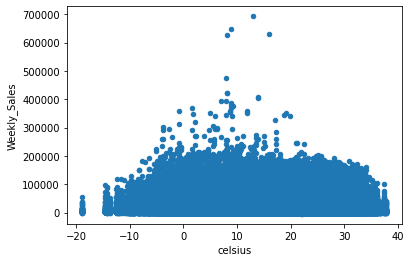

In [31]:
train.plot.scatter("celsius", "Weekly_Sales")

In [32]:
grouped_sales = train.groupby("Date")["celsius"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="magenta", title="Temperature vs Datetime", relative_y_axis=True, height=200)
show(p)

/home/tales/anaconda3/lib/python3.7/site-packages/bokeh/plotting/helpers.py:628: UserWarning: WheelZoomTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [33]:
grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=200)
show(p)

In [34]:
train["celsius"].corr(train["Weekly_Sales"])

-0.0023124470102593737

In [35]:
train["celsius_diff"].corr(train["Weekly_Sales"])

-0.0007430589483357949

# <font color="navy">Size</font>

0.8276068405388468


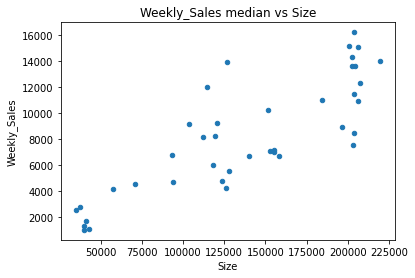

In [36]:
size_sales = train.groupby("Size")["Weekly_Sales"].median().reset_index()
print(size_sales["Size"].corr(size_sales["Weekly_Sales"]))
size_sales.plot.scatter("Size", "Weekly_Sales", title="Weekly_Sales median vs Size")

# <font color="navy">Markdown</font>

In [37]:
mds = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

In [38]:
for md in mds:
    print(md+":", round(train[md].corr(train["Weekly_Sales"]), 4))

MarkDown1: 0.0853
MarkDown2: 0.0241
MarkDown3: 0.0604
MarkDown4: 0.0454
MarkDown5: 0.0904


# Exploring Transformations

Overlaying year Store-Dept Sales Plot

In [39]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [40]:
store_dept = train["store_dept"].sample().iloc[0]
store_dept

'6_27'

In [41]:
store_dept_sales = train[train["store_dept"] == store_dept].set_index("Date")
years = store_dept_sales["year"].drop_duplicates().to_list()[0:2]
years

[2010, 2011]

In [42]:
dy1 = store_dept_sales[store_dept_sales["year"] == years[0]]
dy2 = store_dept_sales[store_dept_sales["year"] == years[1]].reset_index()
dy2["Date"] = dy2["Date"].str.slice(4,10).apply(lambda dt : str(years[0]) + str(dt))
dy2 = dy2.set_index("Date")

In [43]:
pretties.display_md("#### Store-Dept: {}".format(store_dept))

#### Store-Dept: 6_27

In [65]:
p = plot.plot_time_series_count(dy1.index, dy1["Weekly_Sales"], color="navy", title="Weekly_Sales vs Datetime", 
                                relative_y_axis=True, height=300, legend=str(years[0]), p=None)
p = plot.plot_time_series_count(dy2.index, dy2["Weekly_Sales"], color="magenta", title="Weekly_Sales vs Datetime", 
                                relative_y_axis=True, height=300, legend=str(years[1]), p=p)

show(p)

In [66]:
cycle1, trend1 = hpfilter(dy1["Weekly_Sales"], lamb=0.5)
cycle2, trend2 = hpfilter(dy2["Weekly_Sales"], lamb=0.5)

p = plot.plot_time_series_count(dy1.index, trend1, color="cyan", title="Weekly_Sales vs Datetime", 
                                relative_y_axis=True, height=300, line_width=3, legend="hp " + str(years[0]), p=p)
p = plot.plot_time_series_count(dy2.index, trend2, color="#FFC0C8", title="Weekly_Sales vs Datetime", 
                                relative_y_axis=True, height=300, line_width=3, legend="hp " + str(years[1]), p=p)

p.legend.location = 'top_center'
show(p)

In [ ]:


grouped_sales = train.groupby("Date")["Weekly_Sales"].median()
display(grouped_sales)
gdp_cycle, gdp_trend = hpfilter(grouped_sales, lamb=1)

p = plot.plot_time_series_count(grouped_sales.index, grouped_sales, color="navy", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=300, p=None)
p = plot.plot_time_series_count(grouped_sales.index, gdp_trend, color="magenta", title="Weekly_Sales vs Datetime", relative_y_axis=True, height=300, p=p)

show(p)